In [104]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2
from pycocotools.coco import COCO

# Other Imports
from tqdm.notebook import tqdm

import json

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

train/validation json 파일의 index를 지정

In [105]:
index = 5

train json 파일을 읽는다.

In [106]:
train_file_path = f"./kfold/coco/filter_0/nsplit5/train_cv_{index}.json"

coco = COCO(train_file_path)
    
train_df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
annid = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))
        annid.append(ann['id'])

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max
train_df['ann_id'] = annid

train_df['area'] = ((train_df['y_max'] - train_df['y_min'])*(train_df['x_max'] - train_df['x_min']))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


validation json 파일을 읽는다.

In [107]:
val_file_path = f"./kfold/coco/filter_0/nsplit5/val_cv_{index}.json"

coco = COCO(val_file_path)
    
val_df = pd.DataFrame()

image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
annid = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))
        annid.append(ann['id'])

val_df['image_id'] = image_ids
val_df['class_name'] = class_name
val_df['class_id'] = class_id
val_df['x_min'] = x_min
val_df['y_min'] = y_min
val_df['x_max'] = x_max
val_df['y_max'] = y_max
val_df['ann_id'] = annid

val_df['area'] = ((train_df['y_max'] - train_df['y_min'])*(train_df['x_max'] - train_df['x_min']))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


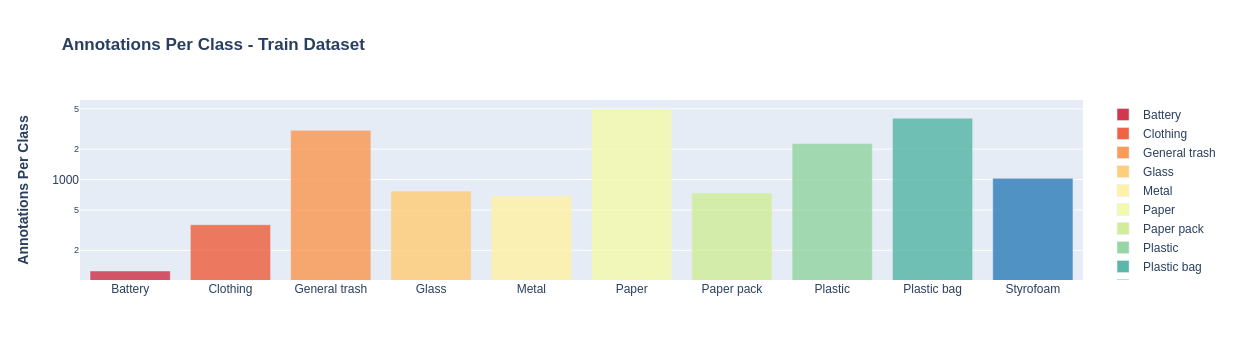

In [108]:
fig = px.bar(train_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class - Train Dataset</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

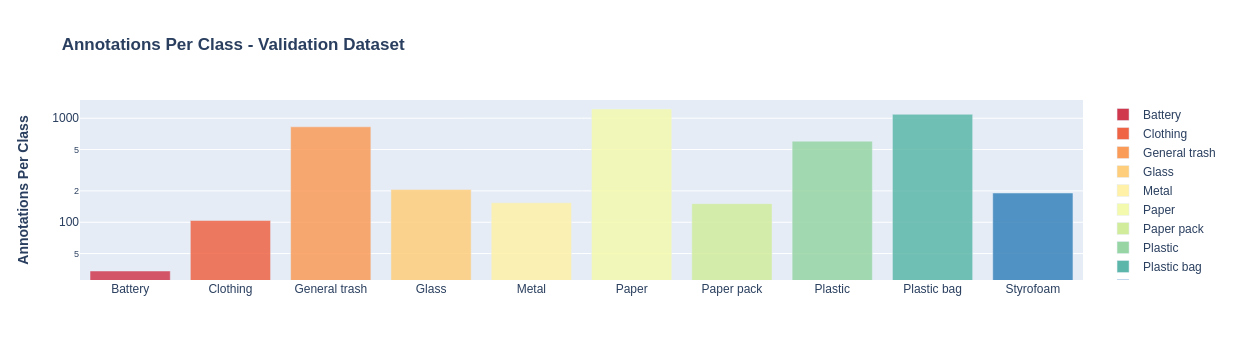

In [109]:
fig = px.bar(val_df.class_name.value_counts().sort_index(), 
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=True,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class - Validation Dataset</b>",)
fig.update_layout(legend_title=None,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

In [110]:
train_image_id_lists = train_df['image_id'].values.tolist()
val_image_id_lists = val_df['image_id'].values.tolist()
train_image_id_lists = set(train_image_id_lists)
val_image_id_lists = set(val_image_id_lists)

In [111]:
path = "/opt/ml/dataset/"

listfile = open(f"./train_cv_{index}.txt", 'w')

for train_image_id in train_image_id_lists:
    listfile.write(path + train_image_id)
    listfile.write("\n")    
listfile.close()

listfile = open(f"./val_cv_{index}.txt", 'w')

for val_image_id in val_image_id_lists:
    listfile.write(path + val_image_id)
    listfile.write("\n")    
listfile.close()